Reads in all SLCs and calculates TPC over time for each pixel then calculate average TPC for each. 
<br>

written on 5-1-2023. Edited by Rowena and Olivia on 5-5-2023.
***

In [1]:
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter, uniform_filter
%matplotlib  widget

In [2]:
workdir = '/data/ocp4/LagunaSalada/Data_and_Figs/'
cropdir = 'cropped_9000_1800_18000_3600/'

# how much to downlook?
alooks=8
rlooks=20

dates = [os.path.basename(x) for x in glob.glob(workdir+cropdir+"SLC_vv/2*")]
dates=sorted(dates)
nd=len(dates); numIgrams = nd-1; numTriplets = nd-2
print(str(nd)+' dates!') 

#larger area
dx = 4000
dy = 1100

211 dates!


In [3]:
#SLCs = np.zeros((nd,dy,dx),dtype='complex')

# larger box with western mtns
x1 = 18000; x2 = 14000
y1 = 2100;  y2 = 1000

# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')


In [4]:
#make tpc one triplet at a time, loading as you go
TPCsum = np.ndarray((dy,dx),dtype='float')
TPCsqsum = np.ndarray((dy,dx),dtype='float')
TPCrms = np.ndarray((dy,dx),dtype='float')
for i in range(nd-2): #number of triplets
    if(np.remainder(i,10)==0):
        print(str(i))
        
    if i == 0:
        ds  = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full",gdal.GA_ReadOnly)
        ds1 = ds.GetRasterBand(1).ReadAsArray(x2,y2,x1-x2,y1-y2)
        ds  = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i+1]+"/"+dates[i+1]+".slc.full",gdal.GA_ReadOnly)
        ds2 = ds.GetRasterBand(1).ReadAsArray(x2,y2,x1-x2,y1-y2)
        ds  = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i+2]+"/"+dates[i+2]+".slc.full",gdal.GA_ReadOnly)
        ds3 = ds.GetRasterBand(1).ReadAsArray(x2,y2,x1-x2,y1-y2)
        int12 = ds1*np.conj(ds2)
        int23 = ds2*np.conj(ds3)
        int13 = ds1*np.conj(ds3)
        ab_filt_r = gaussian_filter(np.real(int12), sigma=[alooks/2,rlooks/2]) # 
        ab_filt_i = gaussian_filter(np.imag(int12), sigma=[alooks/2,rlooks/2]) # Check older code to make sure dividing by 4 was correct for older application 
        ab_filt =   ab_filt_r + 1j*ab_filt_i
        bc_filt_r = gaussian_filter(np.real(int23), sigma=[alooks/2,rlooks/2]) # 
        bc_filt_i = gaussian_filter(np.imag(int23), sigma=[alooks/2,rlooks/2]) # Check older code to make sure dividing by 4 was correct for older application 
        bc_filt =   bc_filt_r + 1j*bc_filt_i
        ac_filt_r = gaussian_filter(np.real(int13), sigma=[alooks/2,rlooks/2]) # 
        ac_filt_i = gaussian_filter(np.imag(int13), sigma=[alooks/2,rlooks/2]) # Check older code to make sure dividing by 4 was correct for older application 
        ac_filt =   ac_filt_r + 1j*ac_filt_i     
        
    else:
        ds1 = ds2;
        ds2 = ds3;
        ds = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i+2]+"/"+dates[i+2]+".slc.full",gdal.GA_ReadOnly)
        ds3 = ds.GetRasterBand(1).ReadAsArray(x2,y2,x1-x2,y1-y2)
        ab_filt = bc_filt
        int23 = ds2*np.conj(ds3)
        int13 = ds1*np.conj(ds3)
        bc_filt_r = gaussian_filter(np.real(int23), sigma=[alooks/2,rlooks/2]) # 
        bc_filt_i = gaussian_filter(np.imag(int23), sigma=[alooks/2,rlooks/2]) # Check older code to make sure dividing by 4 was correct for older application 
        bc_filt =   bc_filt_r + 1j*bc_filt_i
        ac_filt_r = gaussian_filter(np.real(int13), sigma=[alooks/2,rlooks/2]) # 
        ac_filt_i = gaussian_filter(np.imag(int13), sigma=[alooks/2,rlooks/2]) # Check older code to make sure dividing by 4 was correct for older application 
        ac_filt =   ac_filt_r + 1j*ac_filt_i
        
    tmp=np.angle(ab_filt * bc_filt * np.conj(ac_filt))
    TPCsum=TPCsum+tmp
    TPCsqsum=TPCsqsum+np.square(tmp)
print('done.')
        
TPCavg = TPCsum/(nd-2)
TPCrms = np.sqrt(TPCsqsum/(nd-2))
TPCstd = np.sqrt((TPCsqsum - 2*TPCavg*TPCsum + np.square(TPCavg))/(nd-2))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


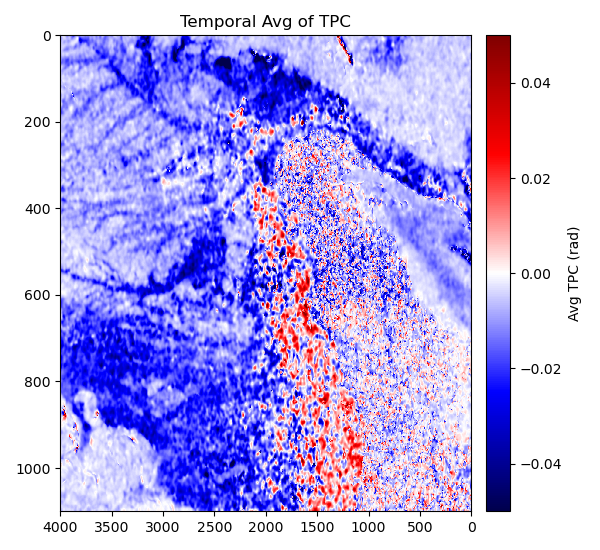

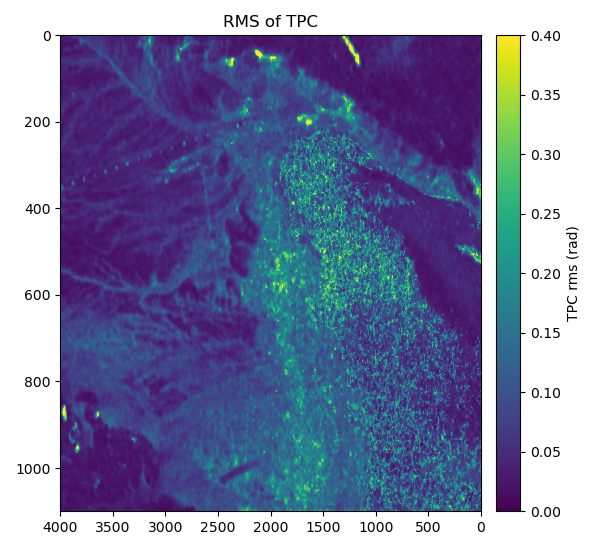

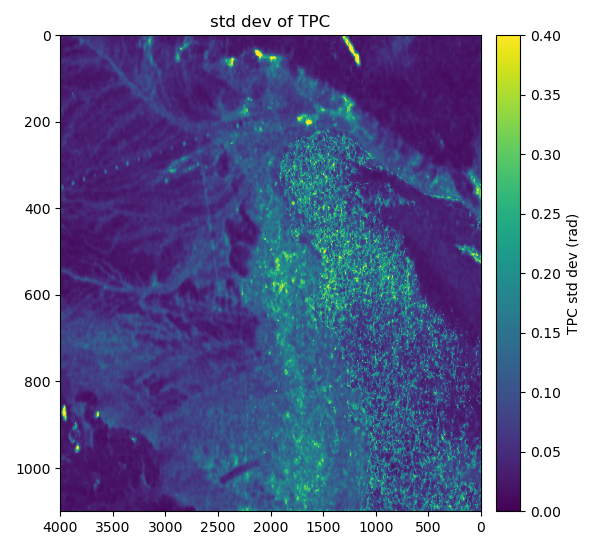

In [6]:
# plot it. 
plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(TPCavg,aspect='auto',interpolation='nearest',vmin=-0.05,vmax=0.05)
plt.colorbar(orientation='vertical',pad=0.03,label='Avg TPC (rad)'); plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([])
plt.title('Temporal Avg of TPC')
plt.show()
plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(TPCrms,aspect='auto',interpolation='nearest',vmin=0,vmax=0.4)
plt.colorbar(orientation='vertical',pad=0.03,label='TPC rms (rad)'); plt.set_cmap('viridis')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([])
plt.title('RMS of TPC')
plt.show()
plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(TPCstd,aspect='auto',interpolation='nearest',vmin=0,vmax=0.4)
plt.colorbar(orientation='vertical',pad=0.03,label='TPC std dev (rad)'); plt.set_cmap('viridis')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([])
plt.title('std dev of TPC')
plt.show()

In [7]:
# save it as an ISCE-readable file. 
driver=gdal.GetDriverByName('ISCE')
#saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/'
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'

save_file_name = 'TPC_sums.r4'
colds = driver.Create(saveDir+save_file_name,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(TPCsum)
colds=None
print('Cumulative TPC for each pixel over time saved.')

save_file_name = 'TPC_avgs.r4'
colds = driver.Create(saveDir+save_file_name,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(TPCavg)
colds=None
print('Average TPC for each pixel over time saved.')

save_file_name = 'TPC_rms.r4'
colds = driver.Create(saveDir+save_file_name,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(TPCrms)
colds=None
print('RMS of TPC for each pixel over time saved.')

save_file_name = 'TPC_stds.r4'
colds = driver.Create(saveDir+save_file_name,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(TPCstd)
colds=None
print('Standard deviation of TPC for each pixel over time saved.')

Cumulative TPC for each pixel over time saved.
Average TPC for each pixel over time saved.
RMS of TPC for each pixel over time saved.
Standard deviation of TPC for each pixel over time saved.
